In [1]:
import random

import arviz as az
import matplotlib.pylab as plt
import networkx as nx
import netwulf as nw
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import subprocess

In [30]:
# GRAPH GENERATORS #
# ---------------- #


def generate_small_graph(N=100, num_duplicates=1, seed=2):
    """Create a single component AB graph. Good for testing.

    After generation the `num_duplicates` most high-degree nodes are cloned. This
    mimicks the common motif in criminal comms networks where persons use multiple
    devices.

    Args:
        N: Number of nodes
        num_duplicates: Number of max-degree nodes that are cloned
    """
    G = nx.extended_barabasi_albert_graph(N-num_duplicates, 1, 0.4, 0.1, seed=seed)

    # Duplicate max degree nodes
    max_degree_nodes = sorted(G.nodes(), key=lambda x: G.degree(x), reverse=True)[
        :num_duplicates
    ]
    for node in max_degree_nodes:

        # Duplicate the selected node
        node_dup = max(G.nodes()) + 1

        # Add a link to each of its original's neighbors
        for _, neighbor, data in G.edges(node, data=True):
            G.add_edge(node_dup, neighbor, **data)

    return G


def generate_big_graph(
    num_communities=5,
    min_community_size=10,
    max_community_size=1000,
    num_duplicates=100,
    seed=2,
):
    """Create a multi component graph, where each component is an AB graph.

    After generation the `num_duplicates` most high-degree nodes are cloned. This
    mimicks the common motif in criminal comms networks where persons use multiple
    devices.
    """
    # Generate community sizes (scales as power law)
    community_sizes = np.logspace(
        np.log10(min_community_size),
        np.log10(max_community_size),
        num_communities,
        base=10,
    ).astype(int)

    # Generate graph. Each community is an isolated graph with a power law degree distribution
    G = nx.Graph()
    for i, n in enumerate(community_sizes):
        G_ = generate_small_graph(n, num_duplicates=0, seed=seed + i)

        # rename nodes
        mapping = {node: node + sum(community_sizes[:i]) for node in G_.nodes()}
        G_ = nx.relabel_nodes(G_, mapping)

        # Add to main graph
        G = nx.compose(G, G_)

    # Add random connections
    num_random_edges = 100
    for _ in range(num_random_edges):
        u = random.randint(0, sum(community_sizes) - 1)
        v = random.randint(0, sum(community_sizes) - 1)
        G.add_edge(u, v)

    # Duplicate max degree nodes
    max_degree_nodes = sorted(G.nodes(), key=lambda x: G.degree(x), reverse=True)[
        :num_duplicates
    ]
    for node in max_degree_nodes:
        node_dup = max(G.nodes()) + 1
        for _, neighbor, data in G.edges(node, data=True):
            G.add_edge(node_dup, neighbor, **data)

    return G


# PyMC UTILS #
# ---------- #


def cosine_sim_pt(matrix: pt.TensorVariable) -> pt.TensorVariable:
    """Computes the pairwise cosine similarity between rows of a pytensor matrix."""
    norm_matrix = matrix / pt.sqrt(pt.sum(matrix**2, axis=1, keepdims=True))
    return pt.dot(norm_matrix, norm_matrix.T)


def cosine_sim_np(matrix: np.ndarray) -> np.ndarray:
    """Computes the pairwise cosine similarity between rows of a numpy matrix."""
    norm_matrix = matrix / np.sqrt(np.sum(matrix**2, axis=1, keepdims=True))
    return np.dot(norm_matrix, norm_matrix.T)


def tril(matrix: pt.TensorVariable, k=-1) -> pt.TensorVariable:
    """Extract the lower triangle of a symmetric TensorVariable."""
    rows, cols = pt.tril_indices_from(matrix, k=k)
    return matrix[rows, cols]

Text(0.5, 1.0, 'Big graph')

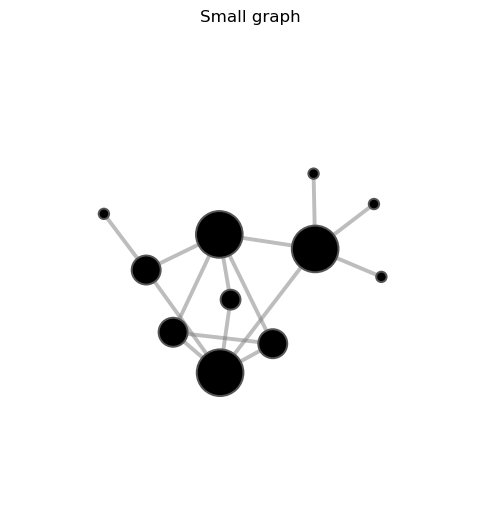

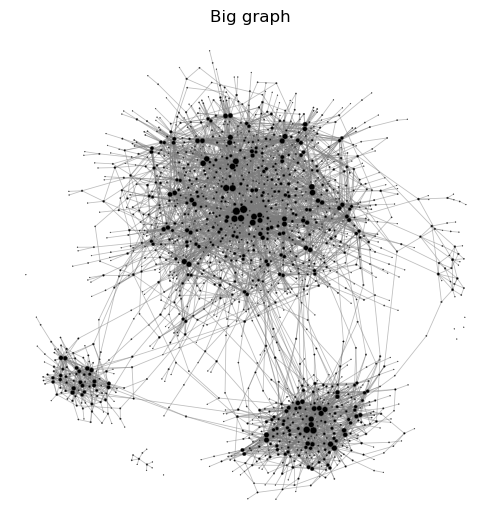

In [13]:
# GENERATE DATA #
# ------------- #

G_small = generate_small_graph(N=10)
properties, _ = nw.visualize(G_small, plot_in_cell_below=True)
fig, ax = nw.draw_netwulf(properties)
ax.set_title("Small graph")

G_big = generate_big_graph()
properties, _ = nw.visualize(G_big, plot_in_cell_below=True)
fig, ax = nw.draw_netwulf(properties)
ax.set_title("Big graph")


**Model that uses NxN assignment matrix**. Doesn't really work...

In [49]:
# Use the small graph as data
G = G_small.copy()

# Cast data as numpy array
adj_matrix = nx.adjacency_matrix(G).toarray()
N = adj_matrix.shape[0]
tril_mask = np.tril(np.ones((N, N)), k=-1).astype(bool)  # Adjacency matrix is symmetical, so we mask to get lower triangle

# MODEL: cluster nodes into "persons", where two nodes have a high likelihood of belonging
# to the same person if:
#   1. They are *not* connected by a link (people don't text themselves)
#   2. They have similar neighbors
with pm.Model() as model:

    # Prior for the node-person assignment probability. Ideally  mess
    p_assignment = pm.Dirichlet(
        "p_assignment", a=np.ones((N, N)), shape=(N, N)
    )

    # The probabilities of phones belonging to the same person. If the dot product of the
    # assignments of node i and node j is close to 1, it is because their assignment dists
    # are near-identical (and concentrated on a single person).
    p_same_person = pm.Deterministic(
        "p_same_person", tril(pm.math.dot(p_assignment, p_assignment.T))
    )

    # The probability of two nodes belonging to different persons
    p_diff_persons = pm.Deterministic(
        "p_diff_persons", 1 - p_same_person
    )

    # Likelihood term 1:
    # -> If two nodes are adjacent, `p_same_person` should be small
    likelihood = pm.Bernoulli(
        "p_adjacent",
        p=p_diff_persons,
        observed=adj_matrix[tril_mask],
    )

    # Likelihood term 2:
    # -> If two nodes have similar neighbors, `p_same_person` should be large
    likelihood += pm.Bernoulli(
        "p_same_neighbors",
        p=p_same_person,
        observed=cosine_sim_np(adj_matrix)[tril_mask],
    )    

    # Inference
    trace = pm.sample(
        draws=4000,
        tune=1000,
        chains=6,
        return_inferencedata=True,
        nuts_sampler="numpyro",
    )

# # send_notification("Execution finished", "Model fit")

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

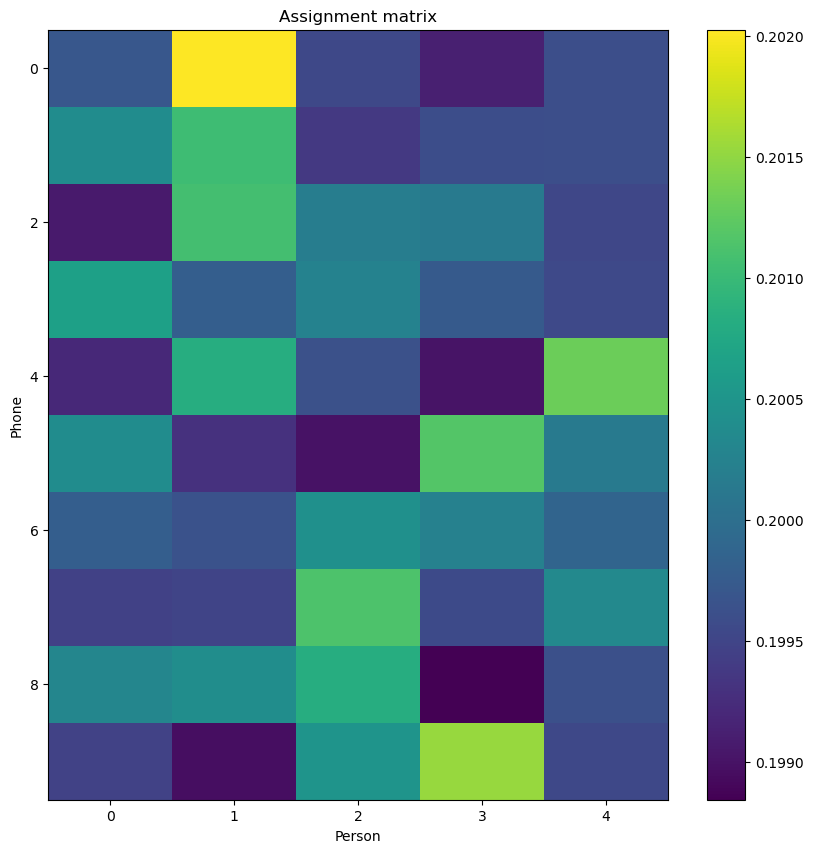

array([1, 1, 1, 0, 4, 3, 2, 2, 2, 3])

In [47]:
# get the fitted assignment matrix
p_assignment_map = trace.posterior.p_assignment.mean(dim=("chain", "draw")).values

# Plot the assignment matrix
plt.figure(figsize=(10, 10))
plt.imshow(p_assignment_map, cmap="viridis", aspect="auto")
plt.colorbar()
plt.xlabel("Person")
plt.ylabel("Phone")
plt.title("Assignment matrix")
plt.show()

# Extract phone-person mapping
phone_person_mapping = np.argmax(p_assignment_map, axis=1)
phone_person_mapping


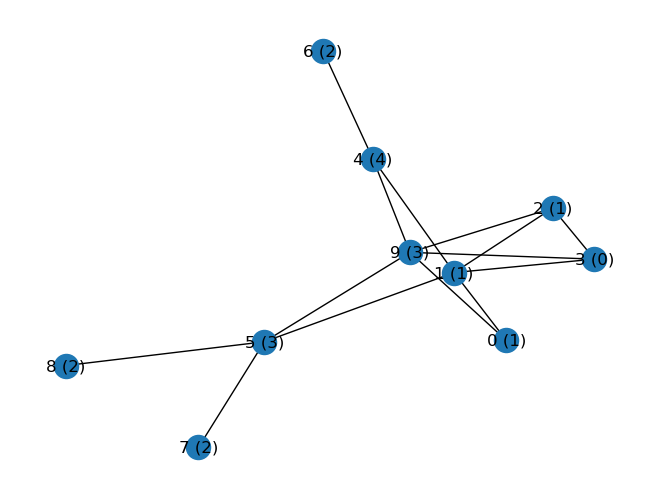

In [48]:
# nx draw with node id labels
def draw_network(G, node_labels=None):
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, labels=node_labels)
    plt.show()
draw_network(G, node_labels={node: f"{node} ({phone_person_mapping[node]})" for node in G.nodes()})

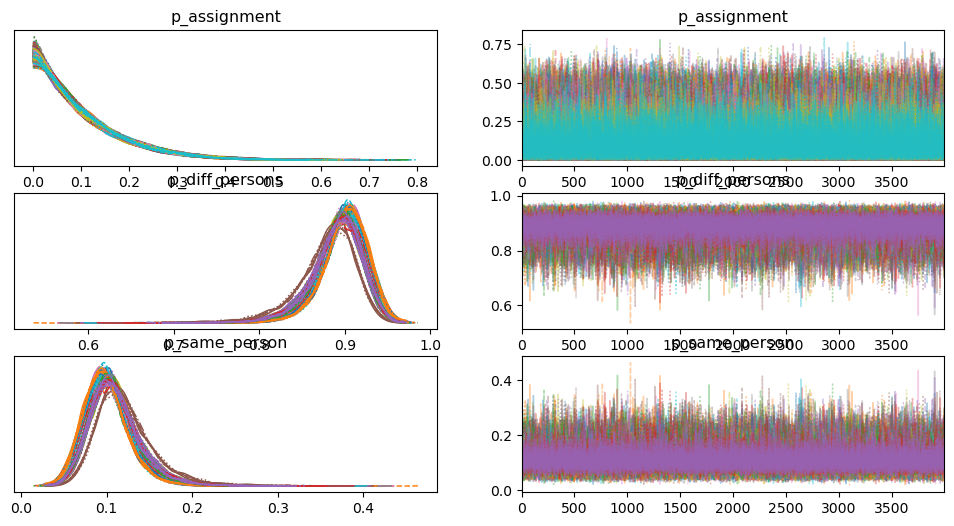

In [50]:
# Plot the results
az.plot_trace(trace)
plt.show()

**Model that uses 1xN assignment float index**. Sparser parameterization that is still continuous

In [85]:
def pairwise_similarity(vector):
    """Compute the pairwise similarity between elements of a 1D vector.

    Args:
        vector (pytensor.tensor): A 1D PyTensor tensor.

    Returns:
        pytensor.tensor: A 2D PyTensor tensor containing the pairwise Euclidean distances.
    """
    distances = 1 - pt.abs(vector[:, None] - vector[None, :])
    normed_distances = distances / (vector.shape[0] - 1)
    return 1 - normed_distances


# Use the small graph as data
G = G_small.copy()

# Cast data as numpy array
adj_matrix = nx.adjacency_matrix(G).toarray()
N = adj_matrix.shape[0]
tril_mask = np.tril(np.ones((N, N)), k=-1).astype(
    bool
)  # Adjacency matrix is symmetical, so we mask to get lower triangle

# MODEL: cluster nodes into "persons", where two nodes have a high likelihood of belonging
# to the same person if:
#   1. They are *not* connected by a link (people don't text themselves)
#   2. They have similar neighbors
with pm.Model() as model:

    # Prior for the node-person assignment probability. Assignment is modeled as a float
    assignment_index = pm.Uniform("assignment_index", lower=0, upper=N - 1, shape=N)

    # The probabilities of phones belonging to the same person. If the similarity of the
    # assignments of node i and node j is close to 1, it is because their assignment dists
    # are near-identical (and concentrated on a single person).
    p_same_person = pm.Deterministic(
        "p_same_person", tril(pairwise_similarity(assignment_index))
    )

    # The probability of two nodes belonging to different persons
    p_diff_persons = pm.Deterministic("p_diff_persons", 1 - p_same_person)

    # Likelihood term 1:
    # -> If two nodes are adjacent, `p_same_person` should be small
    likelihood = pm.Bernoulli(
        "p_adjacent",
        p=p_diff_persons,
        observed=adj_matrix[tril_mask],
    )

    # Likelihood term 2:
    # -> If two nodes have similar neighbors, `p_same_person` should be large
    likelihood += pm.Bernoulli(
        "p_same_neighbors",
        p=p_same_person,
        observed=cosine_sim_np(adj_matrix)[tril_mask],
    )

    # Inference
    trace = pm.sample(
        draws=4000,
        tune=1000,
        chains=6,
        return_inferencedata=True,
        nuts_sampler="numpyro",
    )

# # send_notification("Execution finished", "Model fit")

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

There were 24000 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


/opt/homebrew/Caskroom/mambaforge/base/envs/police-workshop/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/homebrew/Caskroom/mambaforge/base/envs/police-workshop/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/homebrew/Caskroom/mambaforge/base/envs/police-workshop/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


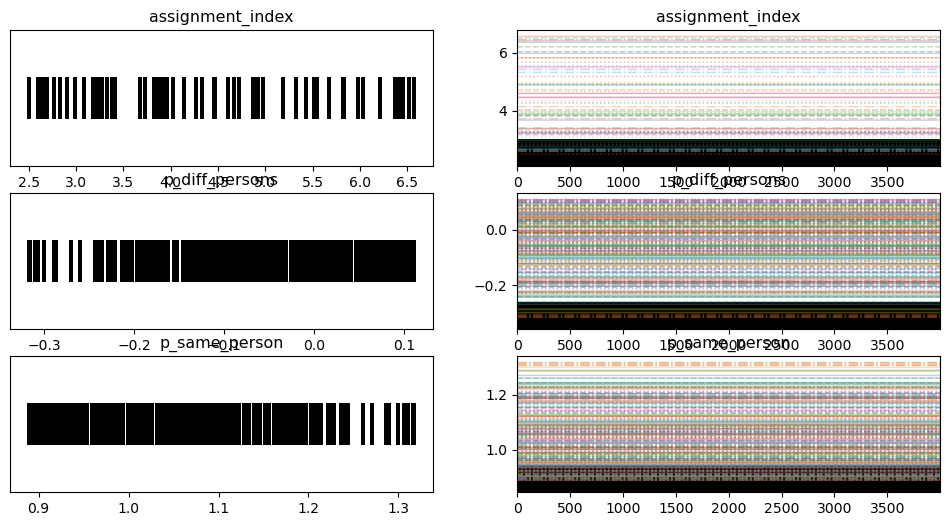

In [87]:
az.plot_trace(trace);

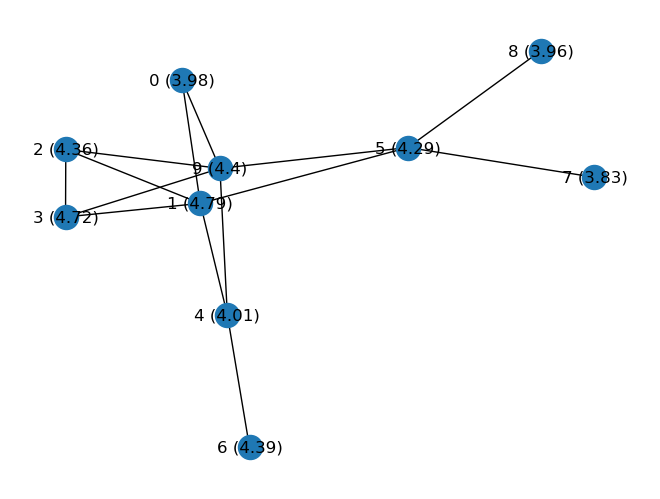

In [86]:
assignment_index = trace.posterior.assignment_index.mean(dim=("chain", "draw")).values

# nx draw with node id labels
def draw_network(G, node_labels=None):
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, labels=node_labels)
    plt.show()

draw_network(G, node_labels={node: f"{node} ({round(assignment_index[node], 2)})" for node in G.nodes()})